# IMPORT LIBRAIRIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

np.set_printoptions(precision=1, suppress=True, linewidth=200)

# DECLARE HYPERPARAMETERS

In [2]:
FILTER_SIZE = (9, 9)
N_GROUPS = 4
GRP_1 = [0, 1, 2, 3]  # I (end) primers
GRP_2 = [4, 5, 6, 7]  # T primers
GRP_3 = [8, 9, 10, 11]  # L (corner) primers
GRP_4 = [12]  # X (cross) primers
N_FILTERS = 32

# LOAD DATA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
lmks_pos = np.load("_lmk_pos_train130.npy")
num_digits = int(np.amax(lmks_pos[:, 0])) + 1
print("Loaded {} primers for {} digits".format(len(lmks_pos), num_digits))
n_cat = int(np.amax(lmks_pos[:, 3]))
print("n_cat:", n_cat)

Loaded 603 primers for 130 digits
n_cat: 12


In [4]:
idx = np.arange(len(lmks_pos))
type_1 = [idx[i] for i in range(len(lmks_pos)) if lmks_pos[i, 3] in GRP_1]
type_2 = [idx[i] for i in range(len(lmks_pos)) if lmks_pos[i, 3] in GRP_2]
type_3 = [idx[i] for i in range(len(lmks_pos)) if lmks_pos[i, 3] in GRP_3]
type_4 = [idx[i] for i in range(len(lmks_pos)) if lmks_pos[i, 3] in GRP_4]
print("num type1: {} ({:.2}%)".format(len(type_1), len(type_1)/len(lmks_pos)))
print("num type2: {} ({:.2}%)".format(len(type_2), len(type_2)/len(lmks_pos)))
print("num type3: {} ({:.2}%)".format(len(type_3), len(type_3)/len(lmks_pos)))
print("num type4: {} ({:.2}%)".format(len(type_4), len(type_4)/len(lmks_pos)))
print("total labeld primers:", len(lmks_pos))

num type1: 231 (0.38%)
num type2: 42 (0.07%)
num type3: 310 (0.51%)
num type4: 20 (0.033%)
total labeld primers: 603


# CREATE PATCH DATASET

In [5]:
def get_patch(lmk, x_train, filt_size=FILTER_SIZE):
    """

    :param lmk_pos: nx4 matrix, with 4 the following parameters: 0: idx of the mnsit img, 1: posX, 2: posX, 3: n_rotate
    :x_train
    :param filt_size:
    :return:
    """
    pad_x = int(filt_size[0] / 2)
    pad_y = int(filt_size[1] / 2)

    # define start and stop
    start_x = lmk[1]-pad_x
    end_x = lmk[1]+pad_x+1
    start_y = lmk[2]-pad_y
    end_y = lmk[2]+pad_y+1
    # print(start_x, end_x, start_y, end_y)

    # define filter for primer
    img = x_train[lmk[0]] / 255.
    patch = img[np.maximum(start_x, 0):end_x, np.maximum(start_y, 0):end_y]

    # add zeros if patch is smaller than the dimension
    if start_x < 0:
        zeros_patch = np.zeros((filt_size[0] - np.shape(patch)[0], np.shape(patch)[1]))
        patch = np.vstack([zeros_patch, patch])
    elif end_x > np.shape(img)[0]:
        zeros_patch = np.zeros((end_x - np.shape(img)[0], np.shape(patch)[1]))
        patch = np.vstack([patch, zeros_patch])
    if start_y < 0:
        zeros_patch = np.zeros((np.shape(patch)[0], filt_size[1] - np.shape(patch)[1]))
        patch = np.hstack([zeros_patch, patch])
    elif end_y > np.shape(img)[1]:
        zeros_patch = np.zeros((np.shape(patch)[0], end_y - np.shape(img)[1]))
        patch = np.hstack([patch, zeros_patch])

    # control size
    if np.shape(patch)[0] != filt_size[0]:
        print("Dimension 0 of patch is not matching ,expected {}, received {}".format(filt_size[0], np.shape(patch)[0]))
    if np.shape(patch)[1] != filt_size[1]:
        print("Dimension 1 of patch is not matching ,expected {}, received {}".format(filt_size[1], np.shape(patch)[1]))

    return patch

In [6]:
def create_patch_dataset(lmks, x_train, group_labels, filt_size=FILTER_SIZE):
    """

    :param lmk_pos: nx4 matrix, with 4 the following parameters: 0: idx of the mnsit img, 1: posX, 2: posX, 3: n_rotate
    :param filt_size:
    :return:
    """
    data = []
    labels = []

    for primer in lmks:
        # print(primer)
        primer_label = primer[3]

        # get patch
        patch = get_patch(primer, x_train, filt_size=filt_size)
        # print(patch)

        # rotate patch
        n_rotate = (N_GROUPS - primer_label%N_GROUPS)%N_GROUPS
        # print("primer_label: {}, n_rotate:{}".format(primer_label, n_rotate))
        patch = np.rot90(patch, n_rotate)
        # print(patch)

        # append patch to dataset
        data.append(patch)

        # set labels
        if primer_label in group_labels:
            labels.append(1)
        else:
            labels.append(0)


    return (np.array(data), np.array(labels))

In [7]:
# (train_x_grp, train_y_grp) = create_patch_dataset(lmks_pos, x_train, GRP_1)
(train_x_grp, train_y_grp) = create_patch_dataset(lmks_pos, x_train, GRP_2)
print("shape train_x_grp", np.shape(train_x_grp))
print("shape train_y_grp", np.shape(train_y_grp))

shape train_x_grp (603, 9, 9)
shape train_y_grp (603,)


primer_type7_idx (25)
[ 14  19  95 102 109 120 161 211 221 238 273 287 294 301 321 363 422 430 444 474 506 519 524 538 543]

id to test: 14, value: 1, lmk_label: [ 2 14 18  7]
rotated patch
[[0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.2 0.1 0.1 0.  0.  0.  0.  0.  0. ]
 [1.  1.  0.8 0.4 0.2 0.  0.  0.  0. ]
 [0.8 0.9 1.  1.  1.  1.  0.9 0.5 0.2]
 [0.  0.1 0.6 1.  0.9 0.9 1.  1.  1. ]
 [0.  0.  0.  0.7 0.7 0.  0.4 0.7 0.7]
 [0.  0.  0.  0.3 0.9 0.1 0.  0.  0. ]
 [0.  0.  0.  0.1 1.  0.4 0.  0.  0. ]
 [0.  0.  0.  0.  0.9 0.6 0.  0.  0. ]]


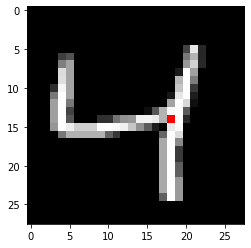

In [8]:
# test rotation
type = 7
idx = np.arange(len(lmks_pos))
primer_type_idx = idx[lmks_pos[:, 3] == type]
print("primer_type{}_idx ({})".format(type, len(primer_type_idx)))
print(primer_type_idx)
print()

id_to_test = 14
print("id to test: {}, value: {}, lmk_label: {}".format(id_to_test, train_y_grp[id_to_test], lmks_pos[id_to_test]))
print("rotated patch")
print(train_x_grp[id_to_test])

plt.figure()
image = x_train[lmks_pos[id_to_test][0]]
rgb_image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2)
rgb_image[lmks_pos[id_to_test][1], lmks_pos[id_to_test][2]] = [255, 0, 0]
plt.imshow(rgb_image)
plt.show()

# CREATE MODEL

In [19]:
def create_simple_model(lr, momentum, n_filters=[N_FILTERS, N_FILTERS, N_FILTERS, N_FILTERS, N_FILTERS], filter_size=FILTER_SIZE, verbose=True, learning_decay=False):
    inputs = tf.keras.Input(shape=(filter_size[0], filter_size[1], 1))

    x = tf.keras.layers.Conv2D(filters=n_filters[0], kernel_size=3, padding='valid', use_bias=False, name="conv_1")(inputs)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters=n_filters[1], kernel_size=3, padding='valid', use_bias=False, name="conv_2")(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters=n_filters[2], kernel_size=3, padding='valid', use_bias=False, name="conv_3")(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters=n_filters[3], kernel_size=3, padding='valid', use_bias=False, name="conv_4")(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=n_filters[4], padding='valid')(tf.reshape(x, [-1, N_FILTERS, 1]))
    outputs = tf.keras.layers.Flatten()(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='LNet')

    if learning_decay:
        lr = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=1000,
            decay_rate=0.9)

    model.compile(optimizer=tf.optimizers.SGD(learning_rate=lr, momentum=momentum), loss='mean_absolute_error')

    if verbose:
        print(model.summary())

    return model

In [20]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / len(train_y_grp[train_y_grp == 0])) * (len(train_y_grp) / 2.0)
weight_for_1 = (1 / len(train_y_grp[train_y_grp == 1])) * (len(train_y_grp) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

grp_model = create_simple_model(lr=0.01, momentum=0.9)
hist = grp_model.fit(x=np.expand_dims(train_x_grp, axis=3), y=train_y_grp, batch_size=64, epochs=60, verbose=1, class_weight=class_weight)

Weight for class 0: 0.54
Weight for class 1: 7.18
Model: "LNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9, 9, 1)]         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 7, 7, 32)          288       
_________________________________________________________________
tf_op_layer_Relu_6 (TensorFl [(None, 7, 7, 32)]        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 5, 5, 32)          9216      
_________________________________________________________________
tf_op_layer_Relu_7 (TensorFl [(None, 5, 5, 32)]        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 3, 3, 32)          9216      
_________________________________________________________________
tf_op_layer_

In [21]:
def predict_primer(image, weights):
    image = tf.convert_to_tensor(np.expand_dims(image, axis=[0, 3]), dtype='float32')
    x_pred = tf.nn.conv2d(image, weights[0], strides=1, padding='SAME', name="conv_1")
    x_pred = tf.keras.activations.relu(x_pred)
    x_pred = tf.nn.conv2d(x_pred, weights[1], strides=1, padding='SAME', name="conv_1")
    x_pred = tf.keras.activations.relu(x_pred)
    x_pred = tf.nn.conv2d(x_pred, weights[2], strides=1, padding='SAME', name="conv_1")
    x_pred = tf.keras.activations.relu(x_pred)
    primers = tf.nn.conv2d(x_pred, weights[3], strides=1, padding='SAME', name="conv_1")

    primers = np.amax(primers.numpy(), axis=(0, -1))

    return primers

In [22]:
# test filters model 2
idx = 2
# image = train_x_grp[14]  # test a patch
image = x_train[idx]/255.
weights = [grp_model.get_layer("conv_1").weights[0],
           grp_model.get_layer("conv_2").weights[0],
           grp_model.get_layer("conv_3").weights[0],
           grp_model.get_layer("conv_4").weights[0]]
primers = predict_primer(image, weights)
print("shape primers", np.shape(primers))
print("min max primers", np.amin(primers), np.amax(primers))

shape primers (28, 28)
min max primers -0.025126405 0.9117926


min max filt_primers -0.025126405 0.9117926
[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2  0.2  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.3  0.4  0.1  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.3  0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.4  0.4  0.1  0. ]
 [ 0.   0.   0.   0.   0.  -0.   0.   0.   0.4  0.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2  0.5  0.3  0.1  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.4  0.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


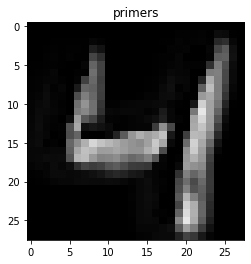

In [23]:
print("min max filt_primers", np.amin(primers), np.amax(primers))
print(primers)
plt.figure()
plt.title("primers")
rgb_image = np.repeat(np.expand_dims(primers, axis=2), 3, axis=2)
plt.imshow(rgb_image)

# TRAIN ALL NETWORKS

In [101]:
class LNet:  # LandmarksNet
    def __init__(self, groups):
        self.groups = groups
        self.models = []
        self.predict_models = []
        self.n_max_group = 4

    def train(self, x, lmks, lr, momentum, learning_decay=False):
        for group in self.groups:
            print("group:", group)
            # create dataset
            (train_x_grp, train_y_grp) = create_patch_dataset(lmks, x, group)

            # compute class weights
            # Scaling by total/2 helps keep the loss to a similar magnitude.
            # The sum of the weights of all examples stays the same.
            weight_for_0 = (1 / len(train_y_grp[train_y_grp == 0])) * (len(train_y_grp) / 2.0)
            weight_for_1 = (1 / len(train_y_grp[train_y_grp == 1])) * (len(train_y_grp) / 2.0)

            class_weight = {0: weight_for_0, 1: weight_for_1}

            print('Weight for class 0: {:.2f}'.format(weight_for_0))
            print('Weight for class 1: {:.2f}'.format(weight_for_1))
            # create model for each group
            grp_model = create_simple_model(lr=lr, momentum=momentum, verbose=False, learning_decay=learning_decay)
            # callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

            # fit models
            hist = grp_model.fit(x=np.expand_dims(train_x_grp, axis=3), y=train_y_grp, batch_size=64, epochs=50, verbose=1, class_weight=class_weight)

            self.models.append(grp_model)

    def predict(self, image):
        preds = []
        for g, group in enumerate(self.groups):
            grp_weights = [self.models[g].get_layer("conv_1").weights[0],
                           self.models[g].get_layer("conv_2").weights[0],
                           self.models[g].get_layer("conv_3").weights[0],
                           self.models[g].get_layer("conv_4").weights[0]]
            for primer in group:
                # compute n_rotate
                n_rotate = primer%self.n_max_group

                # get weights
                weights = []
                for w in grp_weights:
                    rot_weights = np.rot90(w.numpy(), n_rotate, axes=(0, 1))
                    weights.append(rot_weights)  # tf weights:[k_size, k_size, n_in_chanel, n_out_chanel]

                # predict primers
                primers = predict_primer(image, weights)
                preds.append(primers)

        return preds


In [102]:
# build landmark detectors
groups = [[0, 1, 2, 3],  # I (end) primers
          [4, 5, 6, 7],  # T primers
          [8, 9, 10, 11],  # L (corner) primers
          [12]]  # X primers
pimer_detector = LNet(groups)

In [103]:
# train model
pimer_detector.train(x_train, lmks_pos, lr=0.01, momentum=0.9, learning_decay=True)

group: [0, 1, 2, 3]
Weight for class 0: 0.81
Weight for class 1: 1.31
  ...
    to  
  ['...']
Train on 603 samples
Epoch 1/50
603/603 [==============================] - 1s 2ms/sample - loss: 0.5044
Epoch 2/50
603/603 [==============================] - 0s 157us/sample - loss: 0.4611
Epoch 3/50
603/603 [==============================] - 0s 245us/sample - loss: 0.3402
Epoch 4/50
603/603 [==============================] - 0s 138us/sample - loss: 0.1993
Epoch 5/50
603/603 [==============================] - 0s 143us/sample - loss: 0.1501
Epoch 6/50
603/603 [==============================] - 0s 197us/sample - loss: 0.1397
Epoch 7/50
603/603 [==============================] - 0s 182us/sample - loss: 0.1222
Epoch 8/50
603/603 [==============================] - 0s 167us/sample - loss: 0.0996
Epoch 9/50
603/603 [==============================] - 0s 147us/sample - loss: 0.0928
Epoch 10/50
603/603 [==============================] - 0s 212us/sample - loss: 0.0871
Epoch 11/50
603/603 [==============

In [104]:
preds = pimer_detector.predict(x_train[2]/255.)
print("shape preds", np.shape(preds))

shape preds (13, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

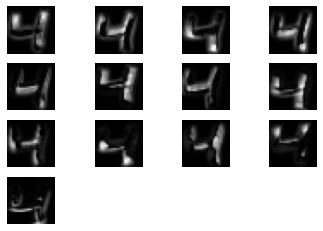

In [105]:
plt.figure()
im_idx = 0
for i in range(4):
    for j in range(4):
        if im_idx < len(preds):
            plt.subplot(4, 4, i*4 + j + 1)
            plt.axis('off')
            rgb_primers = np.repeat(np.expand_dims(preds[im_idx], axis=2), 3, axis=2)
            plt.imshow(rgb_primers)
            im_idx += 1

In [110]:
filt_preds = np.copy(preds)
filt_preds[filt_preds < .9] = 0
filt_preds[filt_preds > 1] = 1

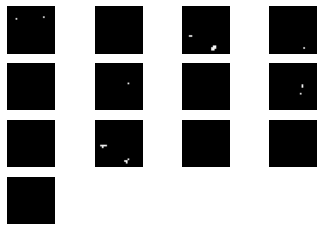

In [111]:
plt.figure()
im_idx = 0
for i in range(4):
    for j in range(4):
        if im_idx < len(filt_preds):
            plt.subplot(4, 4, i*4 + j + 1)
            plt.axis('off')
            rgb_primers = np.repeat(np.expand_dims(filt_preds[im_idx], axis=2), 3, axis=2)
            plt.imshow(rgb_primers)
            im_idx += 1